Import from google drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# !apt-get install tree

In [16]:
# !tree /content/drive/MyDrive/image_class_task_dataset

Random set up - for repeated work will use different notebook for other models

In [17]:
import torch
import numpy as np
import random
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import gc

In [18]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # cuda
    torch.backends.cudnn.benchmark = False  # ensure repeated result for restart session

In [19]:
seed = 42
set_seed(seed)

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #as pre-train used
])

In [21]:
data_dir = '/content/drive/MyDrive/image_class_task_dataset'
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
valid_dataset = datasets.ImageFolder(root=f'{data_dir}/valid', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

In [22]:
def train_and_validate(model, criterion, optimizer, train_loader, valid_loader, scheduler=None,
                       num_epochs=50, grad_clip=None, device='cpu'):
    """
    reocrd changes in loss and acc
    """
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # average loss and acc per whole dataset
        train_loss = running_loss / total_train
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # validation step
        model.eval()
        valid_loss, correct_valid, total_valid = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_valid += (preds == labels).sum().item()
                total_valid += labels.size(0)

        # as above
        valid_loss /= total_valid
        valid_acc = 100 * correct_valid / total_valid
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        # print current progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_acc:.2f}%")

        # change lr if have
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(valid_loss)  # Pass validation loss for ReduceLROnPlateau
            else:
                scheduler.step()  # Step for other scheduler types

    return history

In [23]:
# Define parameters
batch_size = 32
learning_rate = 1e-3
model_type = 'mobilenet'
optimizers = ['SGD']
schedulers = ['ReduceLROnPlateau']

In [24]:
# Set seed once for the whole experiment
set_seed(42)

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_loader.dataset.classes)

In [25]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Storage for experiment results
experiment_results_mobilenet_1 = []

In [26]:
# Experiment loop for optimizers, schedulers, and unfreezing options
for optimizer_type in optimizers:
    for sched in schedulers:
        for unfreeze_all_layers in [True]:  # Loop to control layer freezing

            set_seed(42)

            # Release RAM
            torch.cuda.empty_cache()
            gc.collect()

            # Initialize MobileNet model
            model = models.mobilenet_v2(pretrained=True)
            num_ftrs = model.classifier[1].in_features

            # Modify the final layer to match the number of classes
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)

            # Unfreeze layers based on the flag
            if unfreeze_all_layers:
                for param in model.parameters():
                    param.requires_grad = True
            else:
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.classifier[1].parameters():
                    param.requires_grad = True

            # Move the model to the specified device
            model = model.to(device)

            # Define loss function
            criterion = nn.CrossEntropyLoss()

            # Define optimizer based on current configuration
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

            # Define scheduler based on the current experiment
            if sched == 'CosineAnnealingLR':
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
            elif sched == 'ReduceLROnPlateau':
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
            else:
                scheduler = None

            # Print current configuration
            freeze_status = "All Layers Unfrozen" if unfreeze_all_layers else "Only Last Layer Unfrozen"
            print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={learning_rate}, "
                  f"Optimizer={optimizer_type}, Scheduler={sched}, Freeze Status: {freeze_status}\n")

            # Train and validate
            history = train_and_validate(
                model=model,
                criterion=criterion,
                optimizer=optimizer,
                train_loader=train_loader,
                valid_loader=valid_loader,
                scheduler=scheduler,
                num_epochs=100,
                grad_clip=None,
                device=device
            )

            # Record results
            experiment_results_mobilenet_1.append({
                'model_type': model_type,
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer_type': optimizer_type,
                'scheduler': sched,
                'freeze_status': freeze_status,  # Record the freeze configuration
                'history': history
            })


Training mobilenet with Batch Size=32, LR=0.001, Optimizer=SGD, Scheduler=ReduceLROnPlateau, Freeze Status: All Layers Unfrozen

Epoch [1/100], Train Loss: 1.4645, Train Acc: 24.65%, Valid Loss: 1.1821, Valid Acc: 58.54%
Epoch [2/100], Train Loss: 1.1574, Train Acc: 49.30%, Valid Loss: 1.0750, Valid Acc: 65.85%
Epoch [3/100], Train Loss: 1.0945, Train Acc: 54.93%, Valid Loss: 1.0176, Valid Acc: 68.29%
Epoch [4/100], Train Loss: 0.8454, Train Acc: 72.54%, Valid Loss: 0.8383, Valid Acc: 75.61%
Epoch [5/100], Train Loss: 0.7599, Train Acc: 77.46%, Valid Loss: 0.6856, Valid Acc: 75.61%
Epoch [6/100], Train Loss: 0.6025, Train Acc: 78.87%, Valid Loss: 0.5574, Valid Acc: 80.49%
Epoch [7/100], Train Loss: 0.4966, Train Acc: 83.10%, Valid Loss: 0.4949, Valid Acc: 80.49%
Epoch [8/100], Train Loss: 0.4214, Train Acc: 89.44%, Valid Loss: 0.4183, Valid Acc: 85.37%
Epoch [9/100], Train Loss: 0.3416, Train Acc: 90.14%, Valid Loss: 0.4017, Valid Acc: 90.24%
Epoch [10/100], Train Loss: 0.3166, Train 

In [28]:
import pandas as pd

In [29]:
experiment_df_mobile_1 = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'scheduler': result['scheduler'],
        'freeze_status': result['freeze_status'],
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_mobilenet_1
])

In [30]:
# expand per epch result
experiment_df_mobile_1.to_csv("experiment_results_res.csv", index=False)
print("Experiment results have been saved to experiment_results.csv")

Experiment results have been saved to experiment_results.csv


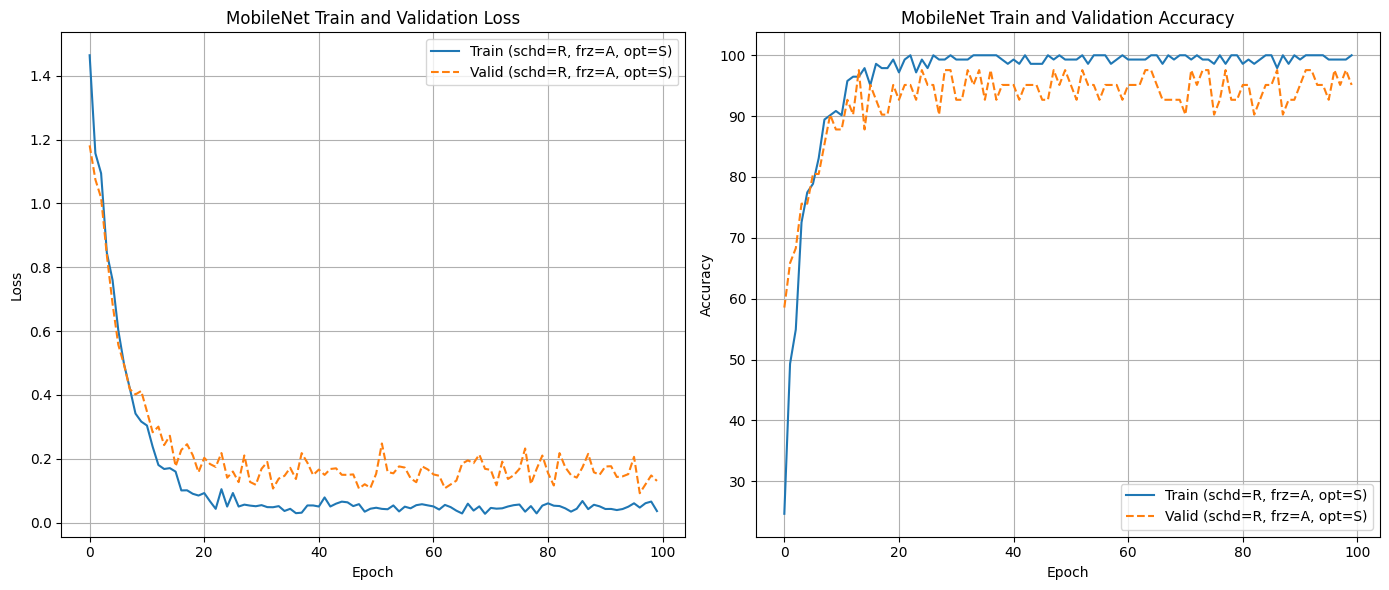

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot train and validation loss
for i, row in experiment_df_mobile_1.iterrows():
    # Create a compact label with scheduler (sched), freeze status (frz), and optimizer (opt)
    label = f"schd={row['scheduler'][0:1]}, frz={'A' if row['freeze_status'] == 'All Layers Unfrozen' else 'L'}, opt={row['optimizer_type'][0:1]}"
    ax1.plot(row['train_loss'], label=f"Train ({label})", linestyle='-')
    ax1.plot(row['valid_loss'], label=f"Valid ({label})", linestyle='--')

ax1.set_title("MobileNet Train and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Plot train and validation accuracy
for i, row in experiment_df_mobile_1.iterrows():
    # Use the same compact label for accuracy plots
    label = f"schd={row['scheduler'][0:1]}, frz={'A' if row['freeze_status'] == 'All Layers Unfrozen' else 'L'}, opt={row['optimizer_type'][0:1]}"
    ax2.plot(row['train_acc'], label=f"Train ({label})", linestyle='-')
    ax2.plot(row['valid_acc'], label=f"Valid ({label})", linestyle='--')

ax2.set_title("MobileNet Train and Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
